In [1]:
import pandas as pd
import os
os.chdir('../')
from python_code import gp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
font = {'size' : 16}
matplotlib.rc('font', **font)

In [2]:
df = pd.read_csv('../data/utilities.csv')
df = df.sort_values('temp')

In [3]:
x = df['temp'].to_numpy()
y = (df['gasbill']/df['billingdays']).to_numpy() 

In [4]:
Gp = gp.GaussianProcess(x.reshape(-1,1), y, sigma_squared=1, bandwidth=50, tau_sq_1=1, tau_sq_2=1e-6)

In [5]:
Gp.fit()
y_pred, CI = Gp.predict(x.reshape(-1,1))

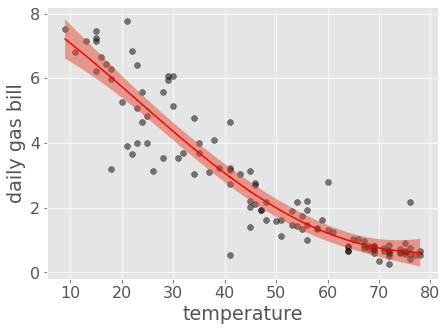

In [6]:
plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha =.5, color='black')
plt.fill_between(x, CI[0], CI[1], alpha=.5)
plt.plot(x, y_pred, color='red')
plt.ylabel('daily gas bill')
plt.xlabel('temperature');

In [7]:
Gp.bandwidth, Gp.tau_sq_1

(60.32880507329933, 36.41824091996292)

In [15]:
n_points = 100
tau_1_range = np.linspace(20, 60, n_points)
b_range = np.linspace(50, 70, n_points)
tt, bb = np.meshgrid(tau_1_range, b_range)
all_tau = tt.flatten()
all_b = bb.flatten()

In [16]:
all_marginals = []
for n in range(len(all_b)):
    parameters = np.array([all_b[n], all_tau[n]])
    Gp = gp.GaussianProcess(x.reshape(-1,1), y, sigma_squared=1)
    marginal = Gp._calculate_marginal_P_y(parameters)
    all_marginals.append(marginal)

In [17]:
best_comb = np.argwhere(np.array(all_marginals) == np.max(all_marginals))

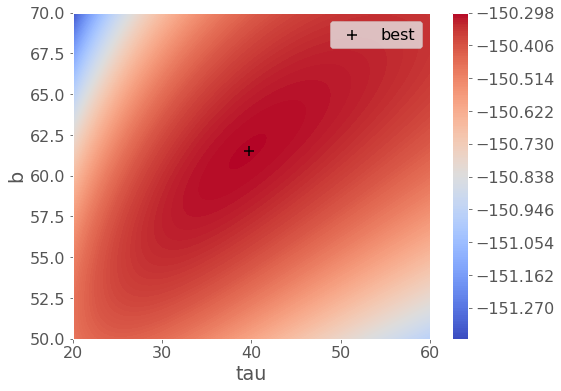

In [18]:
plt.figure(figsize=(8, 6))
plt.contourf(tt, bb, np.array(all_marginals).reshape(n_points,n_points), 200, cmap='coolwarm')
plt.colorbar()
plt.scatter(all_tau[best_comb], all_b[best_comb], color='black', marker='+', label='best', s=100)
plt.xlabel('tau')
plt.ylabel('b')
plt.legend();


In [20]:
all_b[best_comb], all_tau[best_comb]

(array([[61.51515152]]), array([[39.7979798]]))